<a href="https://colab.research.google.com/github/Chionde/ddln/blob/main/sentiTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/StockmarketForecasting

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1J_EmdIHTUM59_fleuEc93nozjhQ_LREU/StockmarketForecasting


In [ ]:
!pip install gensim
from __future__ import division, print_function
from gensim import models
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D,LSTM, GlobalMaxPooling1D, Embedding,Bidirectional
from keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os
import collections
import re
import string

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 82.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 21.1 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1


In [ ]:
data = pd.read_csv('dataset/input.csv')
data

,Label,Ticker,Headline
0,0,MMM,Employer who stole nearly $3M in wages from 15...
1,1,MMM,Huge new Facebook data leak exposed intimate d...
2,0,MMM,A campaign has accelerated to turn a disused r...
3,1,MMM,Google launches global human trafficking helpl...
4,1,MMM,Over 3m Saudi Women Don’t Have ID Cards; Saudi...
...,...,...,...
2376,0,WMT,Walmart dumps e-cigarettes: Largest store in U...
2377,0,WMT,Walmart makes a $16 billion bet on India's boo...
2378,0,WMT,Walmart raises minimum age to buy tobacco to 2...
2379,0,WMT,Walmart Took Over Chile In Only Three Years An...


In [ ]:
pos = []
neg = []
neutral=[]
for l in data.Label:
    if l == 0:
        pos.append(0)
        neg.append(1)
        neutral.append(0)
    elif l == 1:
        pos.append(1)
        neg.append(0)
        neutral.append(0)
    elif l == 2:
        pos.append(0)
        neg.append(0)
        neutral.append(1)

In [ ]:
data['Pos']= pos
data['Neg']= neg
data['Neutral']= neutral
data

,Label,Ticker,Headline,Pos,Neg,Neutral
0,0,MMM,Employer who stole nearly $3M in wages from 15...,0,1,0
1,1,MMM,Huge new Facebook data leak exposed intimate d...,1,0,0
2,0,MMM,A campaign has accelerated to turn a disused r...,0,1,0
3,1,MMM,Google launches global human trafficking helpl...,1,0,0
4,1,MMM,Over 3m Saudi Women Don’t Have ID Cards; Saudi...,1,0,0
...,...,...,...,...,...,...
2376,0,WMT,Walmart dumps e-cigarettes: Largest store in U...,0,1,0
2377,0,WMT,Walmart makes a $16 billion bet on India's boo...,0,1,0
2378,0,WMT,Walmart raises minimum age to buy tobacco to 2...,0,1,0
2379,0,WMT,Walmart Took Over Chile In Only Three Years An...,0,1,0


In [ ]:
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
def remove_punct(text):
    text_nopunct = ''
    text_nopunct = re.sub('['+string.punctuation+']', '', text)
    return text_nopunct
def lower_token(tokens):
    return [w.lower() for w in tokens]
def remove_stop_words(tokens):
    return [word for word in tokens if word not in stoplist]
data['Text_Clean'] = data['Headline'].apply(lambda x: remove_punct(x))
from nltk import word_tokenize, WordNetLemmatizer
tokens = [word_tokenize(sen) for sen in data.Text_Clean]
lower_tokens = [lower_token(token) for token in tokens]
from nltk.corpus import stopwords
stoplist = stopwords.words('english')
filtered_words = [remove_stop_words(sen) for sen in lower_tokens]
result = [' '.join(sen) for sen in filtered_words]
data['Text_Final'] = result
data['tokens'] = filtered_words
data = data[['Text_Final', 'tokens', 'Label', 'Pos', 'Neg','Neutral']]
data

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,Text_Final,tokens,Label,Pos,Neg,Neutral
0,employer stole nearly 3m wages 157 workers fin...,"[employer, stole, nearly, 3m, wages, 157, work...",0,0,1,0
1,huge new facebook data leak exposed intimate d...,"[huge, new, facebook, data, leak, exposed, int...",1,1,0,0
2,campaign accelerated turn disused railway line...,"[campaign, accelerated, turn, disused, railway...",0,0,1,0
3,google launches global human trafficking helpl...,"[google, launches, global, human, trafficking,...",1,1,0,0
4,3m saudi women ’ id cards saudi grand mufti sa...,"[3m, saudi, women, ’, id, cards, saudi, grand,...",1,1,0,0
...,...,...,...,...,...,...
2376,walmart dumps ecigarettes largest store us lon...,"[walmart, dumps, ecigarettes, largest, store, ...",0,0,1,0
2377,walmart makes 16 billion bet indias booming ec...,"[walmart, makes, 16, billion, bet, indias, boo...",0,0,1,0
2378,walmart raises minimum age buy tobacco 21 pres...,"[walmart, raises, minimum, age, buy, tobacco, ...",0,0,1,0
2379,walmart took chile three years countries terri...,"[walmart, took, chile, three, years, countries...",0,0,1,0


In [ ]:
data_train, data_test = train_test_split(data, test_size=0.10, random_state=42)
data_train=data
all_training_words = [word for tokens in data_train["tokens"] for word in tokens]
training_sentence_lengths = [len(tokens) for tokens in data_train["tokens"]]
TRAINING_VOCAB = sorted(list(set(all_training_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_training_words), len(TRAINING_VOCAB)))
print("Max sentence length is %s" % max(training_sentence_lengths))

29626 words total, with a vocabulary size of 7974
Max sentence length is 36


In [ ]:
all_test_words = [word for tokens in data_test["tokens"] for word in tokens]
test_sentence_lengths = [len(tokens) for tokens in data_test["tokens"]]
TEST_VOCAB = sorted(list(set(all_test_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_test_words), len(TEST_VOCAB)))
print("Max sentence length is %s" % max(test_sentence_lengths))

2872 words total, with a vocabulary size of 1774
Max sentence length is 34


In [ ]:
word2vec_path = 'GoogleNews-vectors-negative300.bin.gz'
word2vec = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [ ]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_comments, generate_missing=False):
    embeddings = clean_comments['tokens'].apply(lambda x: get_average_word2vec(x, vectors,
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [ ]:
training_embeddings = get_word2vec_embeddings(word2vec, data_train, generate_missing=True)

In [ ]:
MAX_SEQUENCE_LENGTH = 35
EMBEDDING_DIM = 300
tokenizer = Tokenizer(num_words=len(TRAINING_VOCAB), lower=True, char_level=False)
tokenizer.fit_on_texts(data_train["Text_Final"].tolist())
training_sequences = tokenizer.texts_to_sequences(data_train["Text_Final"].tolist())

train_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(train_word_index))

Found 7974 unique tokens.


In [ ]:
import pickle

with open('tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)

In [ ]:
train_cnn_data = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)
train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))
for word,index in train_word_index.items():
    train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(train_embedding_weights.shape)

(7975, 300)


In [ ]:
test_sequences = tokenizer.texts_to_sequences(data_test["Text_Final"].tolist())
test_cnn_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [ ]:
data_test

,Text_Final,tokens,Label,Pos,Neg,Neutral
1414,boris johnson lied queen get parliament suspen...,"[boris, johnson, lied, queen, get, parliament,...",0,0,1,0
1075,cozy design home depot carpet tiles,"[cozy, design, home, depot, carpet, tiles]",0,0,1,0
1376,excia head intel showed contacts russians trum...,"[excia, head, intel, showed, contacts, russian...",0,0,1,0
2002,salesforce developer,"[salesforce, developer]",1,1,0,0
1104,home depot pay highest penalty ever failing fo...,"[home, depot, pay, highest, penalty, ever, fai...",1,1,0,0
...,...,...,...,...,...,...
239,snowden google facebook microsoft yahoo apple ...,"[snowden, google, facebook, microsoft, yahoo, ...",0,0,1,0
1745,google apple facebook microsoft draft joint le...,"[google, apple, facebook, microsoft, draft, jo...",0,0,1,0
1556,russia shuts 4 mcdonalds restaurants moscow,"[russia, shuts, 4, mcdonalds, restaurants, mos...",0,0,1,0
892,bayermonsanto verge merger dow chemicaldupont ...,"[bayermonsanto, verge, merger, dow, chemicaldu...",1,1,0,0


In [ ]:
label_names = ['Pos', 'Neg','Neutral']
with open('test_cnn.pkl', 'wb') as file:
    pickle.dump(test_cnn_data, file)
with open('test_cnn.pkl', 'wb') as file:
    pickle.dump(test_cnn_data, file)
with open('test_label.pkl', 'wb') as file:
    pickle.dump(data_test[label_names].values, file)

In [ ]:
from tensorflow.keras.layers import (
    Embedding, Input, LSTM, Bidirectional, Conv1D, GlobalMaxPooling1D,
    Dropout, Dense, concatenate
)
from tensorflow.keras.models import Model

def ConvBiLSTMNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index):
    """
    Combines CNN and BiLSTM layers for text classification.

    Args:
        embeddings: Pre-trained embedding weights (e.g., GloVe).
        max_sequence_length: Maximum length of input sequences.
        num_words: Vocabulary size.
        embedding_dim: Dimension of the embedding vectors.
        labels_index: Number of output labels (for classification).

    Returns:
        Compiled Keras model.
    """
    # Embedding layer
    embedding_layer = Embedding(
        input_dim=num_words,
        output_dim=embedding_dim,
        weights=[embeddings],
        input_length=max_sequence_length,
        trainable=False
    )

    # Input layer
    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    # BiLSTM layer with global max pooling
    lstm_layer = Bidirectional(LSTM(64, return_sequences=True))(embedded_sequences)
    lstm_pooled = GlobalMaxPooling1D()(lstm_layer)

    # CNN layers with different filter sizes
    convs = []
    filter_sizes = [2, 3, 4, 5, 6]
    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=200, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = GlobalMaxPooling1D()(l_conv)
        convs.append(l_pool)

    # Merge CNN and BiLSTM outputs
    cnn_merged = concatenate(convs, axis=1)
    combined = concatenate([cnn_merged, lstm_pooled], axis=1)

    # Fully connected layers with dropout
    x = Dropout(0.1)(combined)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    preds = Dense(labels_index, activation='softmax')(x)

    # Build and compile model
    model = Model(sequence_input, preds)
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['acc']
    )
    model.summary()
    return model


In [ ]:
label_names = ['Pos', 'Neg','Neutral']
y_train = data_train[label_names].values
y_test = data_test[label_names].values
x_train = train_cnn_data

y_tr = y_train
model = ConvBiLSTMNet(train_embedding_weights, MAX_SEQUENCE_LENGTH, len(train_word_index)+1, EMBEDDING_DIM,
                len(list(label_names)))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 35)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 35, 300)        │      2,392,500 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 34, 200)        │        120,200 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 33, 200)        │        180,200 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 32, 200)        │        240,200 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, 31, 200)        │        300,200 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_4 (Conv1D)         │ (None, 30, 200)        │        360,200 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_1    │ (None, 200)            │              0 │ conv1d[0][0]           │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_2    │ (None, 200)            │              0 │ conv1d_1[0][0]         │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_3    │ (None, 200)            │              0 │ conv1d_2[0][0]         │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_4    │ (None, 200)            │              0 │ conv1d_3[0][0]         │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_5    │ (None, 200)            │              0 │ conv1d_4[0][0]         │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 35, 128)        │        186,880 │ embedding[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 1000)           │              0 │ global_max_pooling1d_… │
│                           │                        │                │ global_max_pooling1d_… │
│                           │                        │                │ global_max_pooling1d_… │
│                           │                        │                │ global_max_pooling1d_… │
│                           │                        │                │ global_max_pooling1d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d 

 Total params: 3,925,279 (14.97 MB)

 Trainable params: 1,532,779 (5.85 MB)

 Non-trainable params: 2,392,500 (9.13 MB)

In [ ]:
num_epochs = 10
batch_size = 34
hist = model.fit(x_train, y_tr, epochs=num_epochs, validation_data=(test_cnn_data,y_test))

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 105ms/step - acc: 0.5340 - loss: 0.8505 - val_acc: 0.6151 - val_loss: 0.6634
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - acc: 0.6184 - loss: 0.6788 - val_acc: 0.7866 - val_loss: 0.5618
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/step - acc: 0.6840 - loss: 0.6131 - val_acc: 0.8745 - val_loss: 0.4142
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - acc: 0.7703 - loss: 0.4825 - val_acc: 0.8201 - val_loss: 0.3229
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - acc: 0.8523 - loss: 0.3526 - val_acc: 0.9665 - val_loss: 0.1372
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - acc: 0.9228 - loss: 0.2160 - val_acc: 0.9874 - val_loss: 0.0985
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - acc: 0.9398 - loss: 0.1751 - val_acc: 0.9874 - val_loss: 0.0784
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 110ms/step - acc: 0.9717 - loss: 0.0974 - val_acc: 0.9874 - val_loss: 0.0553
Epoch 9/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/st

In [ ]:
model.save('StockNewssentiment.h5')

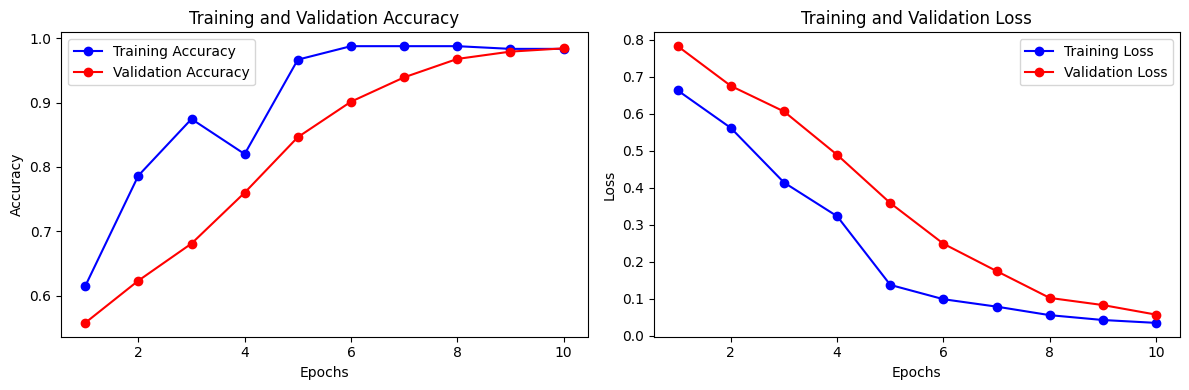

In [ ]:
import matplotlib.pyplot as plt
train_accuracy=[]
val_accuracy=[]
train_loss=[]
val_loss=[]
history=hist
train_accuracy.extend(history.history['acc'])
val_accuracy.extend(history.history['val_acc'])
train_loss.extend(history.history['loss'])
val_loss.extend(history.history['val_loss'])

epochs = range(1, len(train_accuracy) + 1)
# Plotting Training and Validation Accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs,val_accuracy , 'bo-', label='Training Accuracy')
plt.plot(epochs, train_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs,val_loss , 'bo-', label='Training Loss')
plt.plot(epochs, train_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()